In [1]:
import pandas as pd
import numpy as np

from models import *
from series_restr import *
from utils import *

c:\Anaconda3\envs\torch37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
df = pd.read_excel('data/df_eu.xlsx', sheet_name='df-eu')

Xcols = ['Eprice', 'BrentOil', 'CrudeOilF', 'TTF-NatGas', 'NatGasF', 'Coal', 'GasolineF', 'DJI', 'S&P500', 'USD-EUR']
dataX = np.array(df[Xcols]) 
dataY = np.array(df['Cprice']).reshape(-1,1)

print(dataX.shape)
print(dataY.shape)

(1305, 10)
(1305, 1)


1.6642432966693453e-14
1.563246609334534e-14


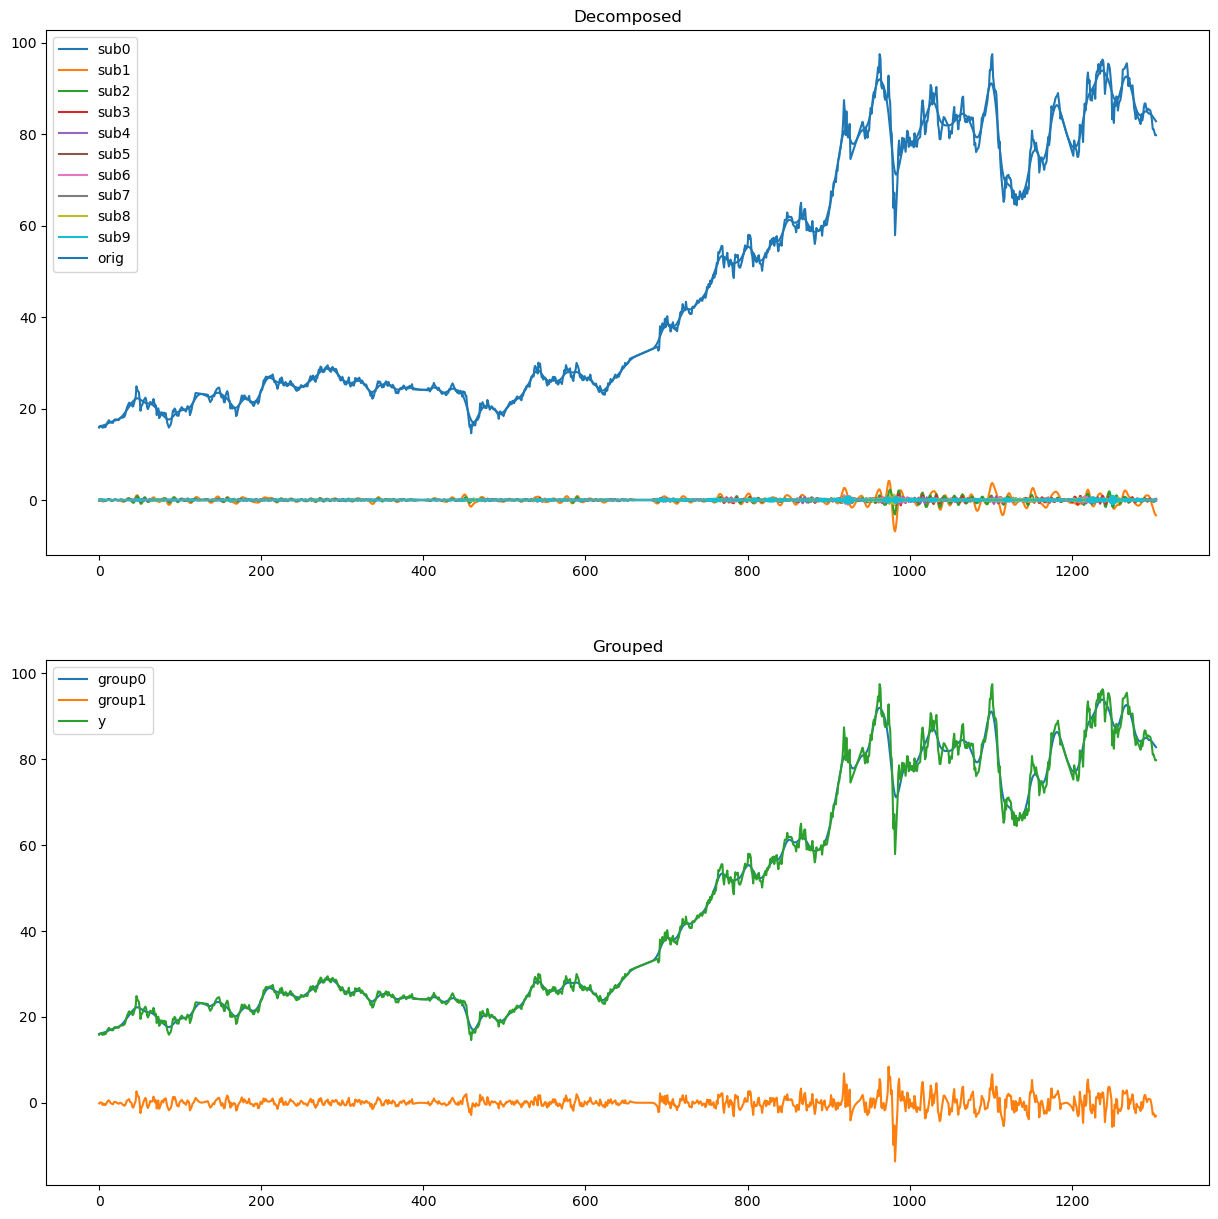

In [7]:
reconstr = restr_ssa(dataY.reshape(-1), n_decomp=10, n_integr=2, vis=True)

In [10]:
reconstr.shape

(2, 1305)

In [13]:
batch_size = 1
pred_len = 10
seq_len = 100

pred = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))
real = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))

batch_size = 1
for i in range(reconstr.shape[0]):
    print(i)
    subY = reconstr[i,:].reshape(-1,1)
    m = TCN_model('sg-nowin-TCN'+str(i), batch_size)
    m.prepare_data(dataX, subY, seq_len=100, pred_len=10)
    m.init_model()
    m.train_model(train_ratio=1, val_ratio=0.2)
    # m.load_model()
    sub_pred, sub_real = m.test_model(test_ratio=1)
    pred += sub_pred
    real += sub_real

0
epoch 001 train_loss 0.00540458 val_loss 0.00446478
epoch 002 train_loss 0.00481594 val_loss 0.00380728
epoch 003 train_loss 0.00546801 val_loss 0.00479815
EarlyStopping counter: 1 out of 7
epoch 004 train_loss 0.00482735 val_loss 0.00328973
epoch 005 train_loss 0.00559781 val_loss 0.00544284
EarlyStopping counter: 1 out of 7
epoch 006 train_loss 0.00478804 val_loss 0.00440359
EarlyStopping counter: 2 out of 7
epoch 007 train_loss 0.00482228 val_loss 0.00649850
EarlyStopping counter: 3 out of 7
epoch 008 train_loss 0.00490657 val_loss 0.00436338
EarlyStopping counter: 4 out of 7
epoch 009 train_loss 0.00461117 val_loss 0.00346360
EarlyStopping counter: 5 out of 7
epoch 010 train_loss 0.00409098 val_loss 0.00312293
epoch 011 train_loss 0.00478479 val_loss 0.00472304
EarlyStopping counter: 1 out of 7
epoch 012 train_loss 0.00492880 val_loss 0.00397971
EarlyStopping counter: 2 out of 7
epoch 013 train_loss 0.00411815 val_loss 0.00445657
EarlyStopping counter: 3 out of 7
epoch 014 train_

performance of hb-nowin-TCN
col 0: RMSE=2.39, MAPE=3.60%
col 1: RMSE=2.37, MAPE=3.57%
col 2: RMSE=2.37, MAPE=3.59%
col 3: RMSE=2.43, MAPE=3.73%
col 4: RMSE=2.42, MAPE=3.79%
col 5: RMSE=2.46, MAPE=3.91%
col 6: RMSE=2.45, MAPE=3.97%
col 7: RMSE=2.50, MAPE=4.09%
col 8: RMSE=2.60, MAPE=4.24%
col 9: RMSE=2.68, MAPE=4.35%


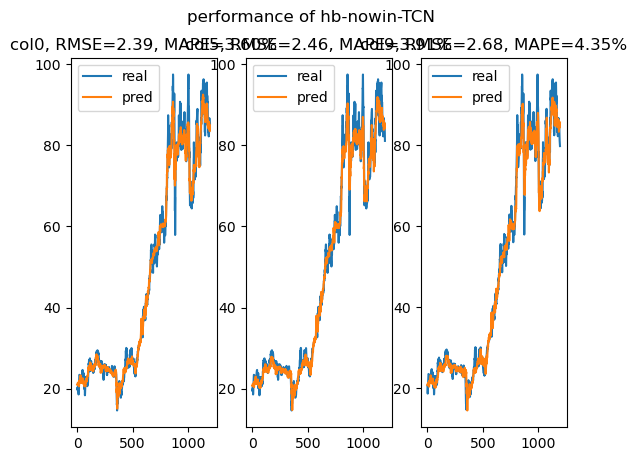

In [14]:
show_performance('hb-nowin-TCN', pred, real, vis=True)

In [9]:
import pandas as pd
import numpy as np
from torchinfo import summary

from models import *
from series_restr import *
from utils import *


batch_size = 1
pred_len = 10
seq_len = 100
train_ratio = 0.9

### load data
df = pd.read_excel('data/df_eu.xlsx', sheet_name='df-eu')
Xcols = ['Cprice', 'Eprice', 'BrentOil', 'CrudeOilF', 'TTF-NatGas', 'NatGasF', 'Coal', 'GasolineF', 'DJI', 'S&P500', 'USD-EUR']
# note: Cprice at previous steps are also features for the current step
dataX = np.array(df[Xcols]) 
dataY = np.array(df['Cprice']).reshape(-1,1)
# print(dataX.shape)
# print(dataY.shape)

In [13]:
import pmdarima as pm
from copy import deepcopy

trail_name = "sg_nowin_arima"
print(colored(trail_name, 'blue'))

split = int( (len(dataY)-seq_len-pred_len+1) * train_ratio ) + seq_len
trainY, testY = dataY[:split], dataY[split:]

# fit arima model with training set
model = pm.auto_arima(  
    trainY, start_p=1, start_q=1,
    max_p=10, max_q=10,         # maximum p and q
    information_criterion='aic',# 'aic', 'aicc', 'bic', 'hqic', 'oob'
    d=None,                     # let model determine 'd'
    test='adf',                 # use adftest to find optimal 'd', or 'kpss', 'pp'
    m=1,                        # frequency of series, m=1 means non-seasonal
    seasonal=False,             # no Seasonality
    trace=False,                # don't print status on the fits
    error_action='ignore',      # don't want to know if an order does not work
    suppress_warnings=True,     # don't want convergence warnings
    stepwise=True               # The stepwise algorithm can be significantly faster than
                                # a non-stepwise selection (i.e., essentially a grid search) 
                                # and is less likely to over-fit the model. 
) 
print(model.summary())


sg_nowin_arima
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1176
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1961.257
Date:                Fri, 10 Nov 2023   AIC                           3936.513
Time:                        13:14:46   BIC                           3971.996
Sample:                             0   HQIC                          3949.893
                               - 1176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.061      0.039       0.000       0.008
ar.L1          0.9893      0.023     43.438      0.000       0.945       1.034
ar.L2          0.0253      0.019     

In [18]:
# predict with test set
pred = []
real = []
for i in range(len(testY)-pred_len+1):
    model_copy = deepcopy(model)
    if i != 0:
        model_copy.update(testY[:i])
    new_pred = model_copy.predict(n_periods=pred_len, return_conf_int=False)
    pred.append(new_pred)
    real.append(dataY[split+i: split+i+pred_len])

pred = np.array(pred)
real = np.array(real)
print(pred.shape)
print(real.shape)
show_performance('sg-nowin-arima', pred, real, vis=True)

KeyboardInterrupt: 

performance of sg-nowin-arima
col 0: RMSE=63.47, MAPE=272.18%
col 1: RMSE=63.46, MAPE=271.85%
col 2: RMSE=63.44, MAPE=271.55%
col 3: RMSE=63.42, MAPE=271.27%
col 4: RMSE=63.40, MAPE=271.02%
col 5: RMSE=63.39, MAPE=270.76%
col 6: RMSE=63.38, MAPE=270.47%
col 7: RMSE=63.36, MAPE=270.14%
col 8: RMSE=63.35, MAPE=269.78%
col 9: RMSE=63.34, MAPE=269.36%


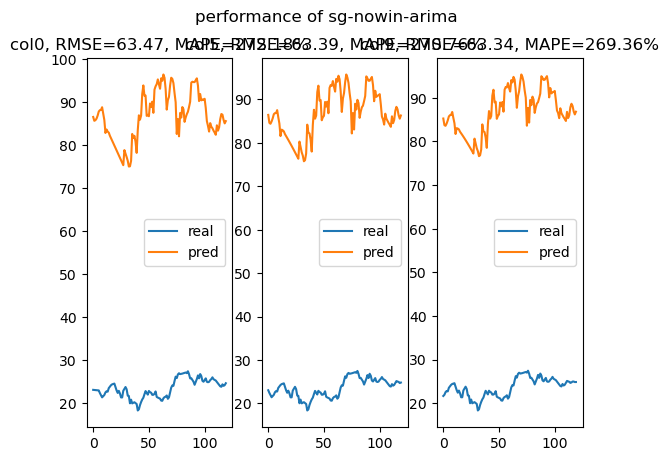

In [12]:

show_performance('sg-nowin-arima', pred, real, vis=True)

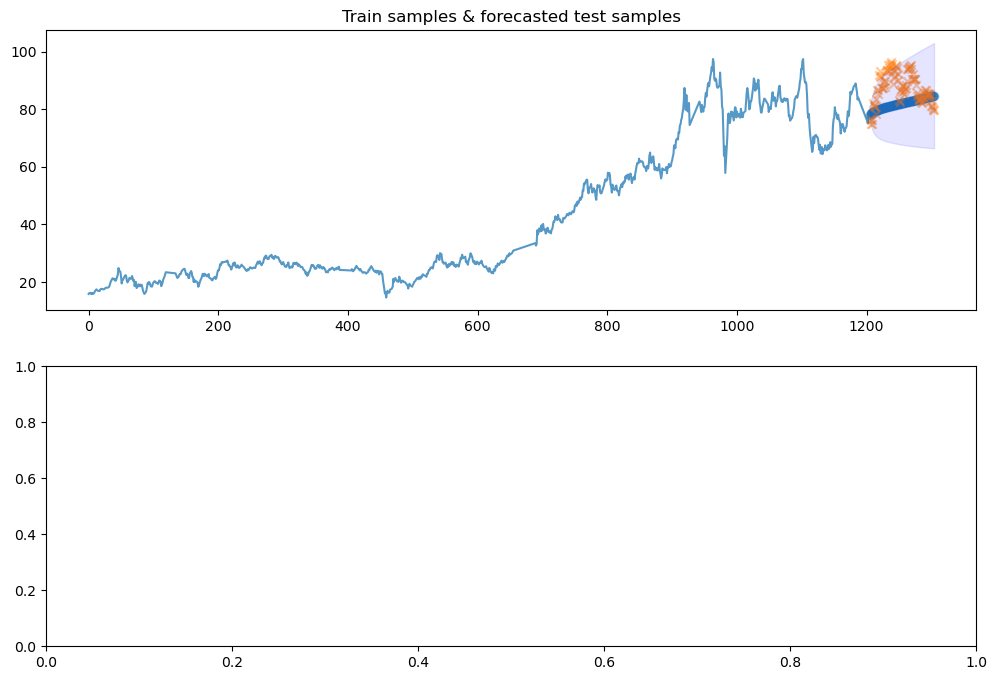

In [42]:
# Now plot the results and the forecast for the test set
preds, conf_int = model.predict(n_periods=testY.shape[0],
                                return_conf_int=True)

plotTrain = 100

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(trainY.shape[0] + preds.shape[0])
axes[0].set_title("Train samples & forecasted test samples")
axes[0].plot(x_axis[:trainY.shape[0]], trainY, alpha=0.75)
axes[0].scatter(x_axis[trainY.shape[0]:], preds, alpha=0.4, marker='o')
axes[0].scatter(x_axis[trainY.shape[0]:], testY, alpha=0.4, marker='x')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')



# Now add the actual samples to the model and create NEW forecasts
model.update(testY)
new_preds, new_conf_int = model.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)

axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()

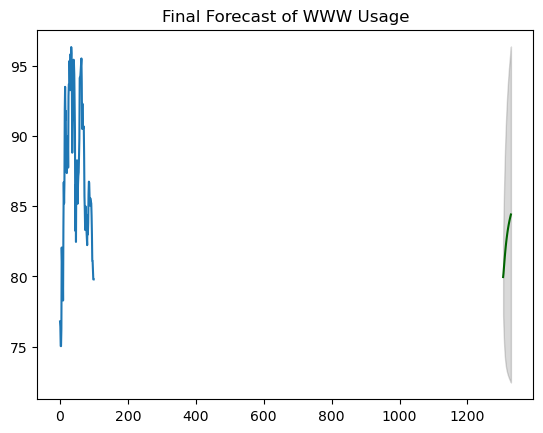

In [18]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(dataY), len(dataY)+n_periods)
 
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
 
# Plot
plt.plot(dataY)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
 
plt.title("Final Forecast of WWW Usage")
plt.show()

c:\Anaconda3\envs\torch37\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Anaconda3\envs\torch37\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Anaconda3\envs\torch37\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Anaconda3\envs\torch37\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Anaconda3\envs\torch37\lib\site-packages\pmdarima\arima\arima.py", line 515, in _fit_wrapper
    **fit_args,
  File "c:\Anaconda3\envs\torch37\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 709, in fit
    skip_hessian=True, **kwargs)
  File "c:\Anaconda3\envs\torch37\lib\site-packag

ValueError: x and y must have same first dimension, but have shapes (176,) and (150,)

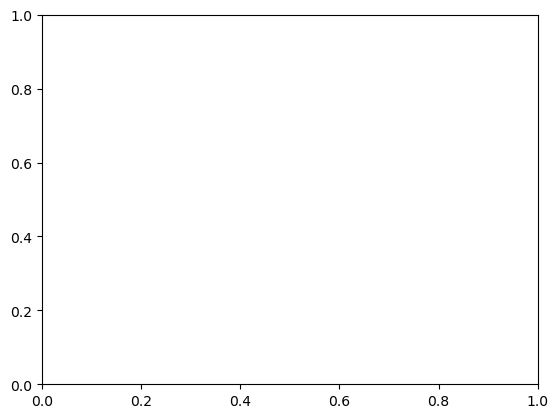

In [34]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
 
# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)
 
# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)
 
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future
 
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

In [33]:
test.shape

(26,)

In [ ]:
 
import pmdarima as pm
from pmdarima import model_selection
import matplotlib.pyplot as plt
import numpy as np
# 加载数据并将其拆分为单独的部分
data = pm.datasets.load_lynx()
train, test = model_selection.train_test_split(data, train_size=100)
# fit一些验证(cv)样本
arima = pm.auto_arima(train, start_p=1, start_q=1, d=0, max_p=5, max_q=5,
                      out_of_sample_size=10, suppress_warnings=True,
                      stepwise=True, error_action='ignore')
 
# 现在绘制测试集的结果和预测
preds, conf_int = arima.predict(n_periods=test.shape[0],
                                return_conf_int=True)
 
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
 
# 填写在模型中"held out"样本的部分
axes[0].set_title("Train samples & forecasted test samples")
 
# 现在将实际样本添加到模型中并创建NEW预测
arima.update(test)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)
 
axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0], new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()